# NHANES I dataset from shap

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from pandas.api.types import is_string_dtype, is_object_dtype, is_categorical_dtype, is_bool_dtype
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'
pd.set_option('display.max_columns', 80)

import shap

from stratx.partdep import *
from impimp import *
from support import *

def fix_missing_num(df, colname):
    df[colname+'_na'] = pd.isnull(df[colname]).astype(int)
    df[colname].fillna(df[colname].median(), inplace=True)

In [62]:
X,y = shap.datasets.nhanesi()
X = X.drop('Unnamed: 0', axis=1)
X['Race'] = X['Race'].astype(int)
X['Sex'] = X['Sex'].astype(int)
n = X.shape[0]
X.head()

,Age,Diastolic BP,Poverty index,Race,Red blood cells,...,TIBC,TS,White blood cells,BMI,Pulse pressure
0,35.0,92.0,126.0,2,77.7,...,323.0,41.8,5.8,31.109434,50.0
1,71.0,78.0,210.0,2,77.7,...,331.0,26.9,5.3,32.362572,78.0
2,74.0,86.0,999.0,2,77.7,...,299.0,38.5,8.1,25.388497,84.0
3,64.0,92.0,385.0,1,77.7,...,349.0,26.9,6.7,26.446610,80.0
4,32.0,70.0,183.0,2,77.7,...,386.0,49.7,8.1,20.354684,58.0


In [63]:
shap_paper_features = ['Age', 'Sex', 'Poverty index', 'Systolic BP', 'Serum Cholesterol',
                       'Pulse pressure', 'BMI', 'White blood cells',
                       'Sedimentation rate', 'TS', 'Serum Magnesium', 
                       'Serum Protein', 'Serum Iron',
                       'Red blood cells', 'Race']

In [64]:
X = X[shap_paper_features].copy()

In [66]:
for feature in ['Sedimentation rate', 'Systolic BP', 'White blood cells', 'Pulse pressure']:
    fix_missing_num(X, feature)

In [67]:
rf = RandomForestRegressor(n_estimators=100, oob_score=True, n_jobs=-1)
rf.fit(X,y)
rf.oob_score_

0.32486566567050346

In [78]:
# From https://slundberg.github.io/shap/notebooks/NHANES%20I%20Survival%20Model.html
def c_statistic_harrell(pred, labels):
    total = 0
    matches = 0
    for i in range(len(labels)):
        for j in range(len(labels)):
            if labels[j] > 0 and abs(labels[i]) > labels[j]:
                total += 1
                if pred[j] > pred[i]:
                    matches += 1
    return matches/total

# see how well we can order people by survival
c_statistic_harrell(rf.predict(X), y)

0.8159726861523267

In [68]:
%time shap_values = shap.TreeExplainer(rf).shap_values(X[:200])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


CPU times: user 42 s, sys: 218 ms, total: 42.2 s
Wall time: 42 s


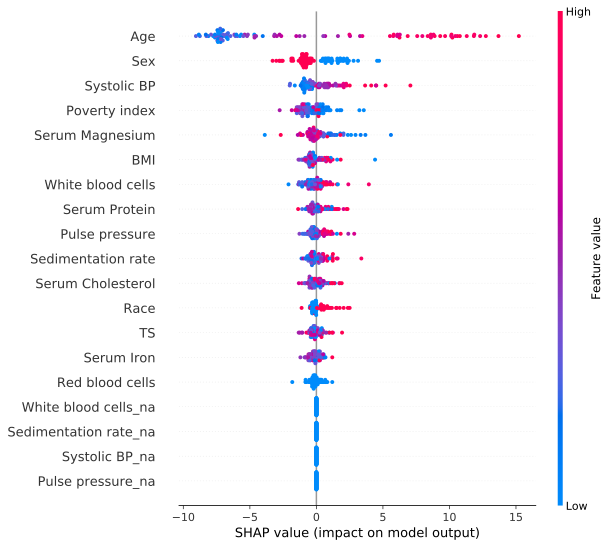

CPU times: user 686 ms, sys: 11 ms, total: 697 ms
Wall time: 696 ms


In [69]:
%time shap.summary_plot(shap_values, X[:200])

In [70]:
shap_I = shap_importances(rf, X, n_shap=100, normalize=True)

SHAP time for 100 records using RandomForestRegressor = 7.4s


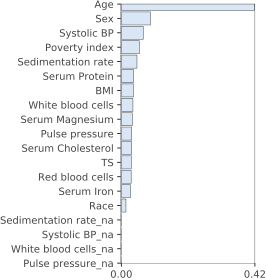

In [71]:
plot_importances(shap_I)

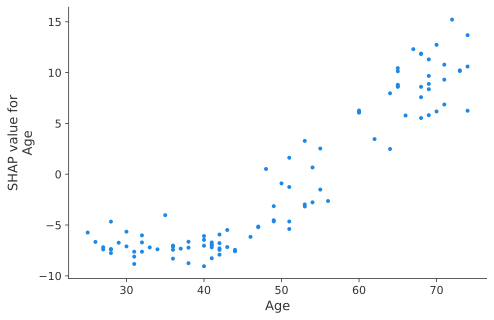

In [72]:
shap.dependence_plot("Age", shap_values, X[:200], interaction_index=None)

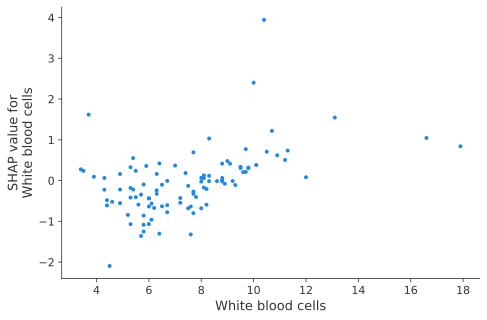

In [73]:
shap.dependence_plot("White blood cells", shap_values, X[:200], interaction_index=None)

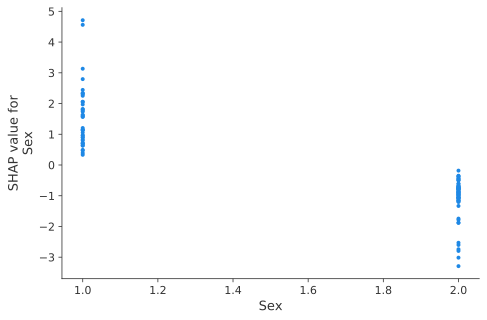

In [74]:
shap.dependence_plot("Sex", shap_values, X[:200], interaction_index=None)

In [75]:
I = impact_importances(X, pd.Series(y), min_samples_leaf=10,
                            catcolnames={'Sex','Race'},
                            min_slopes_per_x=int(n*0.03))

Impact importance time 9s


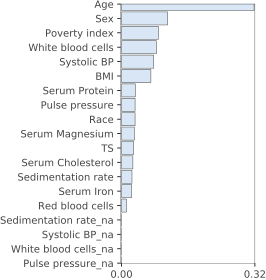

In [76]:
plot_importances(I)

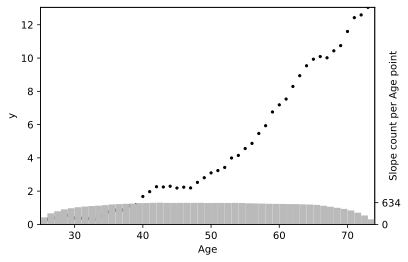

In [79]:
plot_stratpd(X, pd.Series(y), 'Age', 'y',
             show_slope_counts=True,
             min_slopes_per_x=5,
             min_samples_leaf=10,
             show_slope_lines=False)
plt.show()

29.796


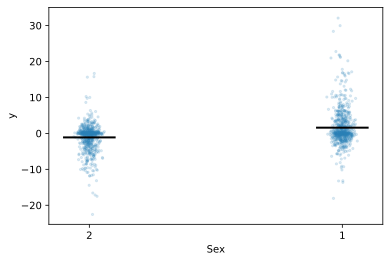

In [82]:
print(n*0.003)
plot_catstratpd(X, pd.Series(y), 'Sex', 'y',
             min_samples_leaf=10,
             min_y_shifted_to_zero=False)
plt.show()